In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 400
df = pd.read_csv("output/result.csv", header=None)
df.columns = ['problem',
              'query',
              'explanation',
              'status',
              'test accuracy',
              'rnn score',
              'LTL explanation score',
              'explanation score on ground truth',
              'LTL extraction time',
              'revised delta',
              'revised epsilon',
              'counterexamples',
              'train size',
              'test size',
              'LTL depth',
            'lstar states',
            'lstar explanation score',
            'lstar explanation score on ground truth',
            'lstar extraction time',
            'lstar status', 
            'epsilon', 
            'delta'
              ]
markersize = 20
fontsize = 32
labelsize = 20


In [18]:
replace_dict = dict(zip([
            #    "d",
            "X",
            '|',
            "U",
            "F",
            "G",
            "&",
            "~",
            "->",
            "true",
            "false",
        ], [

            #    "\\\\circ",
            "_X_",
            "_vee_",
            "_U_",
            "_F_",
            "_G_",
            "_wedge_",
            "_neg_",
            "_rightarrow_",
            "_top_",
            "_bot_",
        ]))

        

In [7]:
import matplotlib.pyplot as plt
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

targets = ["email match"]
query_ = "~F(d)"
fixed_param_values = [0.05, 0.1, 0.25, 0.5]

width = 0.5

show = False


for target in targets:
    for fixed_param_value in fixed_param_values:

        extracted_df=df[(df['problem']==target)]
        

        grouplist=['problem','query','delta']
        for key, item in extracted_df.groupby(grouplist):
            _,query,delta=key
            if(delta != fixed_param_value or query != query_):
                continue
            
            print("\n\n\n")
            print(key)
            
            x_ = 'epsilon'
            
            item = item.sort_values(x_, ascending = True)
            print(item[[ 'LTL explanation','LTL extraction time', 'LTL explanation score', 'epsilon', 'delta']].to_string(index=False))
            
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            ax.bar([i for i in range(len(item[x_].tolist()))],item['extraction time'], width)
            plt.xticks([i for i in range(len(item[x_].tolist()))],item[x_])
            plt.tick_params(labelsize=labelsize)
            plt.ylabel("time (s)", fontsize=fontsize)
            plt.xlabel(r"$"+"\\"+x_+"$", fontsize=fontsize)
            plt.tight_layout()

            if(query==query_):
                target_name=target
                query_name=query
                for key in replace_dict.keys():
                     target_name= target_name.replace(key, replace_dict[key])
                     query_name= query_name.replace(key, replace_dict[key])
                     
                plt.savefig("output/fig/"+target_name.replace(" ", "_")+"_"+query_name+"_"+x_+"_"+str(int(fixed_param_value*100))+"_time.pdf",bbox_inches='tight')
            if(show):
                plt.show()
            plt.clf()

        grouplist=['problem','query','epsilon']


for target in targets:
    for fixed_param_value in fixed_param_values:

        extracted_df=df[(df['target']==target)]

        for key, item in extracted_df.groupby(grouplist):
            _,query,epsilon=key
            if(epsilon != fixed_param_value or query != query_):
                continue
            
            print("\n\n\n")
            print(key)

            x_ = 'delta'
            
            item = item.sort_values(x_, ascending = True)
            print(item[[ 'LTL explanation','LTL extraction time', 'LTL explanation score', 'epsilon', 'delta']].to_string(index=False))
            
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            ax.bar([i for i in range(len(item[x_].tolist()))],item['extraction time'], width)
            plt.xticks([i for i in range(len(item[x_].tolist()))],item[x_])
            plt.tick_params(labelsize=labelsize)
            plt.ylabel("time (s)", fontsize=fontsize)
            plt.xlabel(r"$"+"\\"+x_+"$", fontsize=fontsize)
            plt.tight_layout()
            if(query==query_):
                target_name=target
                query_name=query
                for key in replace_dict.keys():
                     target_name= target_name.replace(key, replace_dict[key])
                     query_name= query_name.replace(key, replace_dict[key])
                     
                plt.savefig("output/fig/"+target_name.replace(" ", "_")+"_"+query_name+"_"+x_+"_"+str(int(fixed_param_value*100))+"_time.pdf",bbox_inches='tight')
            if(show):
                plt.show()
    
            plt.clf()








('email match', '~F(d)', 0.05)
                 explanation  extraction time  explanation score  epsilon  delta
 (X (X (X (X (p U (X p))))))       401.015877              56.39     0.05   0.05
                       false         0.350731             100.00     0.10   0.05
                       false         0.292539             100.00     0.25   0.05
                       false         0.269326             100.00     0.50   0.05




('email match', '~F(d)', 0.1)
                    explanation  extraction time  explanation score  epsilon  delta
                          false         0.432097             100.00     0.05    0.1
                          false         0.341223             100.00     0.10    0.1
 (~ (((~ d) U (X m)) -> (X m)))       401.079384              59.14     0.25    0.1
                          false         0.281676             100.00     0.50    0.1




('email match', '~F(d)', 0.25)
explanation  extraction time  explanation score  epsilon  delta
      f

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [9]:
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 400
df = pd.read_csv("output/result.csv", header=None)
df.columns = ['problem',
              'query',
              'explanation',
              'status',
              'test accuracy',
              'rnn score',
              'LTL explanation score',
              'explanation score on ground truth',
              'LTL extraction time',
              'revised delta',
              'revised epsilon',
              'counterexamples',
              'train size',
              'test size',
              'LTL depth',
            'lstar states',
            'lstar explanation score',
            'lstar explanation score on ground truth',
            'lstar extraction time',
            'lstar status', 
            'epsilon', 
            'delta'
              ]
markersize = 20
fontsize = 32
labelsize = 20

print(df[df['lstar states']==None])

med = df.groupby(['problem','query','epsilon','delta'], as_index=False).median()[['problem','query','LTL explanation score','lstar explanation score','LTL depth','lstar states', 'LTL extraction time','lstar extraction time','revised epsilon','revised delta','rnn score']]

# med = df[['problem','query','LTL explanation score','lstar explanation score','LTL depth','lstar states', 'LTL extraction time','lstar extraction time','revised epsilon','revised delta','rnn score']]


med['summary explainability'] = med.apply(lambda x : "win" if x['LTL depth'] < x['lstar states'] else ("tie" if x['LTL depth'] == x['lstar states'] else "lose"), axis=1)
med['summary accuracy'] = med.apply(lambda x : "win" if x['LTL explanation score'] > x['lstar explanation score'] else ("tie" if x['LTL explanation score'] == x['lstar explanation score'] else "lose"), axis=1)

# med.to_csv("output/average.csv", index=False)
replace_dict = dict(zip([
    "email match",
    "alternating bit protocol",
    'balanced parentheses',
    '&',
    "->"
], [
    'Email',
    'Bit',
    'BP',
    r'$\\wedge$',
    r'$\\rightarrow$'
]))
med['problem'] = med['problem'].replace(replace_dict, regex=True)


Empty DataFrame
Columns: [problem, query, explanation, status, test accuracy, rnn score, LTL explanation score, explanation score on ground truth, LTL extraction time, revised delta, revised epsilon, counterexamples, train size, test size, LTL depth, lstar states, lstar explanation score, lstar explanation score on ground truth, lstar extraction time, lstar status, epsilon, delta]
Index: []

[0 rows x 22 columns]


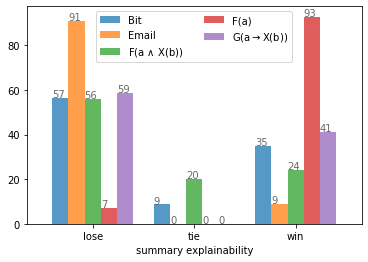

In [10]:
plot_df = 100. * med.groupby('problem')['summary explainability'].value_counts(normalize=True)
ax = plot_df.unstack(0).plot(kind = 'bar',use_index=True, alpha=0.75, rot=0, width=0.8)
ax.legend(loc='best', ncol=2)
# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+.3, \
            str(int(round(i.get_height()))),color='dimgrey')                
ax.figure.savefig("output/fig/explainability.pdf")

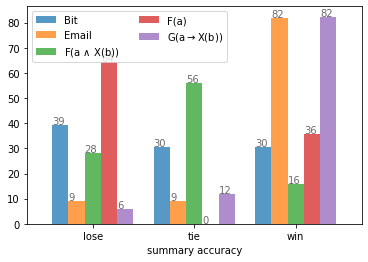

In [11]:
plot_df = 100. * med.groupby('problem')['summary accuracy'].value_counts(normalize=True)
ax = plot_df.unstack(0).plot(kind = 'bar',use_index=True, alpha=0.75, rot=0, width=0.8)
ax.legend(loc='best', ncol=2)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+.3, \
            str(int(round(i.get_height()))),color='dimgrey')                
ax.figure.savefig("output/fig/accuracy.pdf")

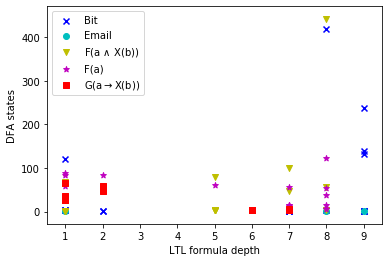

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm
fig, ax = plt.subplots()

# for colors
x = np.arange(10)
ys = [i+x+(i*x)**2 for i in range(10)]
colors = ['b', 'c', 'y', 'm', 'r','g']

marker = ['x', 'o', "v", '*', 's', "p", 'D', '^']
# line = mlines.Line2D([0, 1], [0, 1], color='black')
# transform = ax.transAxes
# line.set_transform(transform)
# ax.add_line(line)
cnt = 0
for key, item in med.groupby(['problem']):
    ax.scatter(x = item['LTL depth'], y = item['lstar states'],marker=marker[cnt], c=colors[cnt], label=key)       
    cnt += 1

ax.set_xlabel("LTL formula depth")
ax.set_ylabel("DFA states")
plt.legend(loc='best',frameon=True)
plt.savefig('output/fig/explainability.pdf')

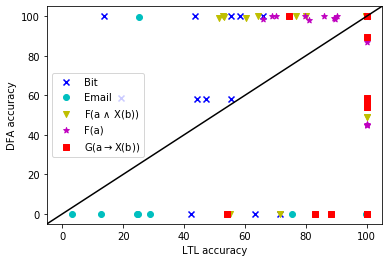

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm
fig, ax = plt.subplots()

# for colors
x = np.arange(10)
ys = [i+x+(i*x)**2 for i in range(10)]
colors = ['b', 'c', 'y', 'm', 'r','g']

marker = ['x', 'o', "v", '*', 's', "p", 'D', '^']
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
cnt = 0
for key, item in med.groupby(['problem']):
    ax.scatter(x = item['LTL explanation score'], y = item['lstar explanation score'],marker=marker[cnt], c=colors[cnt], label=key)       
    cnt += 1
ax.set_xlim([-5,105])
ax.set_ylim([-5,105])
ax.set_xlabel("LTL accuracy")
ax.set_ylabel("DFA accuracy")
plt.legend(loc='best',frameon=True)
plt.savefig('output/fig/accuracy.pdf')